# Tutorial 1: Beam shapes and sizes

This tutorial will show you how to estimate the shape and sizes of beams from the LOFAR telescope.

First, let's load the python libraries that we will use.

In [28]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Exercise 1: Properties of an HBA tile
We start by computing the properties of an HBA tile, which consists of a $4\times4$ arrangment on HBA dipoles. The spacing between dipoles is 1.25m. 
* Use the `np.repeat` and `np.tile` functions of `numpy` to generate two arrays for the $x$ and $y$ positions of the 16 dipoles. (Note that in the notebook you can use `?` after a function to see what it does and how it is called.)
* Plot the positions with `matplotlib`'s `plt.plot`.

In [63]:
x = np.repeat(10.25*np.linspace(-1.5, 1.5, 4), 4)
y = np.tile(10.25*np.linspace(-1.5, 1.5, 4), 4)

Text(0.5,1,'HBA Tile')

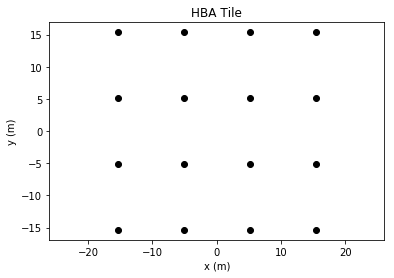

In [64]:
plt.figure()
plt.plot(x, y, "ko")
plt.axis("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("HBA Tile")

Next, let's look at the baselines of an HBA tile.
* Given 16 dipoles, how many baselines will there be?
* Write a python function that given coordinates of dipoles ($x$ and $y$), returns baseline positions (let's call them $b_x$ and $b_y$).
* Compute and plot the baselines. Use transparant markers with `ko` as marker and `alpha=0.1` for the transparancy.

In [65]:
def compute_baselines(x, y):
    n = len(x)
    m = int(n*(n-1)/2)
    bx, by = np.zeros(m), np.zeros(m)
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            bx[k] = x[i]-x[j]
            by[k] = y[i]-y[j]
            k+=1
    return bx, by

In [66]:
bx, by = compute_baselines(x, y)

Text(0,0.5,'$b_y$ (m)')

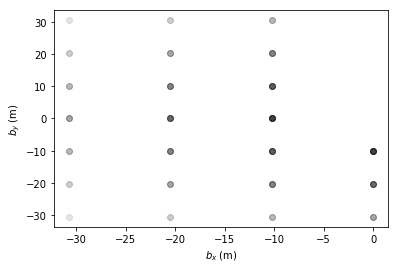

In [67]:
plt.plot(bx, by, 'ko', alpha=0.1)
plt.xlabel("$b_x$ (m)")
plt.ylabel("$b_y$ (m)")

You will see that many of the baselines are redundant.
* Use `np.unique` to compute and count the baseline lenghts ($b=\sqrt{b_x^2+b_y^2}$), and plot these.

(0, 30)

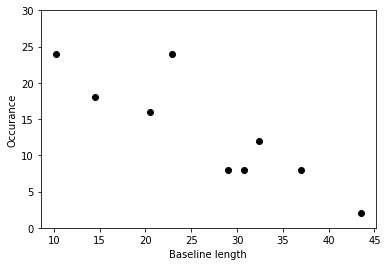

In [68]:
b = np.sqrt(bx**2+by**2)
b_uniq, b_count = np.unique(b, return_counts=True)
plt.plot(b_uniq, b_count, 'ko')
plt.xlabel("Baseline length")
plt.ylabel("Occurance")
plt.ylim(0,30)

Now it is time to look at the $uv$-plane.
* Create a function that computes $u$ and $v$ positions expressed in wavelengths. Use a center frequency of $\nu=150$ MHz. Remember that the $uv$-plane also contains the reflected baselines (see `np.concatenate`).

In [69]:
def uv_positions(bx, by, freq):
    wavelength = 299792458.0/freq
    return np.concatenate((bx, -bx))/wavelength, np.concatenate((by, -by))/wavelength

In [70]:
u, v = uv_positions(bx, by, 150e6)

Text(0,0.5,'$v$ ($\\lambda$)')

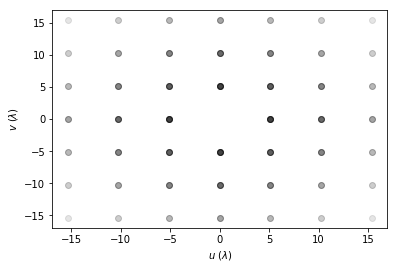

In [71]:
plt.plot(u, v, 'ko', alpha=0.1)
plt.xlabel("$u$ ($\lambda$)")
plt.ylabel("$v$ ($\lambda$)")

The next step is to use these discrete points in the $uv$-plane to an image, of which we can take the 2 dimensional Fourier transform. The function below takes the $uv$ points and generates this image.

In [72]:
def imager(u, v, freq, nl, nm):
    nu = len(u)
    l, m = np.meshgrid(np.linspace(-1.0, 1.0, nl), np.linspace(-1.0, 1.0, nm))
    arg = 2j*np.pi*freq/299792458.0
    print(type(arg))
    img = np.zeros(nl*nm*nu).reshape(nu, nl, nm).astype('complex')
    for i in range(nu):
        img[i] = np.exp(arg*(u[i]*l+v[i]*m))
    
    return np.mean(img, axis=0)

<class 'complex'>
(1000, 1000)


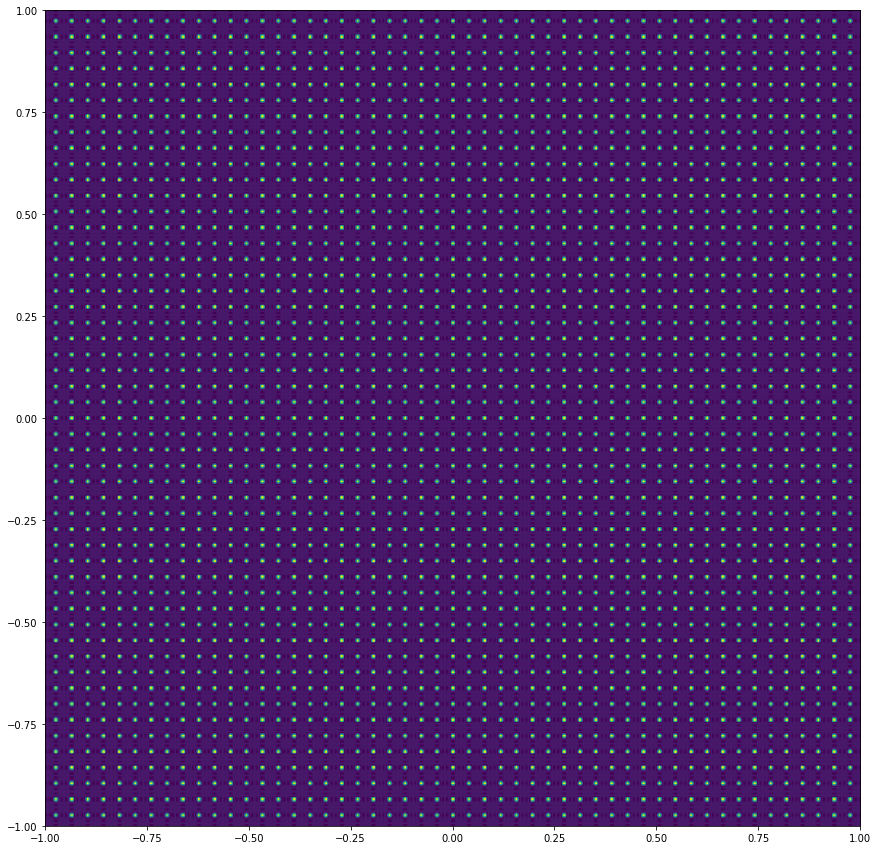

In [76]:
img = imager(u, v, 1500e6, 1000, 1000)
print(img.shape)
plt.figure(figsize=(15,15))
plt.imshow(np.abs(img), extent=[-1, 1, -1, 1])

In [61]:
def uv_image(u, v, width, npix):
    """Generate an UV image of physical size width x width, with a resolution of npix x npix"""
    xyrange = np.array([[-width/2.0, width/2.0], [-width/2.0, width/2.0]])
    uv, lu, lv = scipy.histogram2d(u, v, range=xyrange, bins=npix)
    return uv

In [106]:
uv = uv_image(u, v, 10.0, 101)

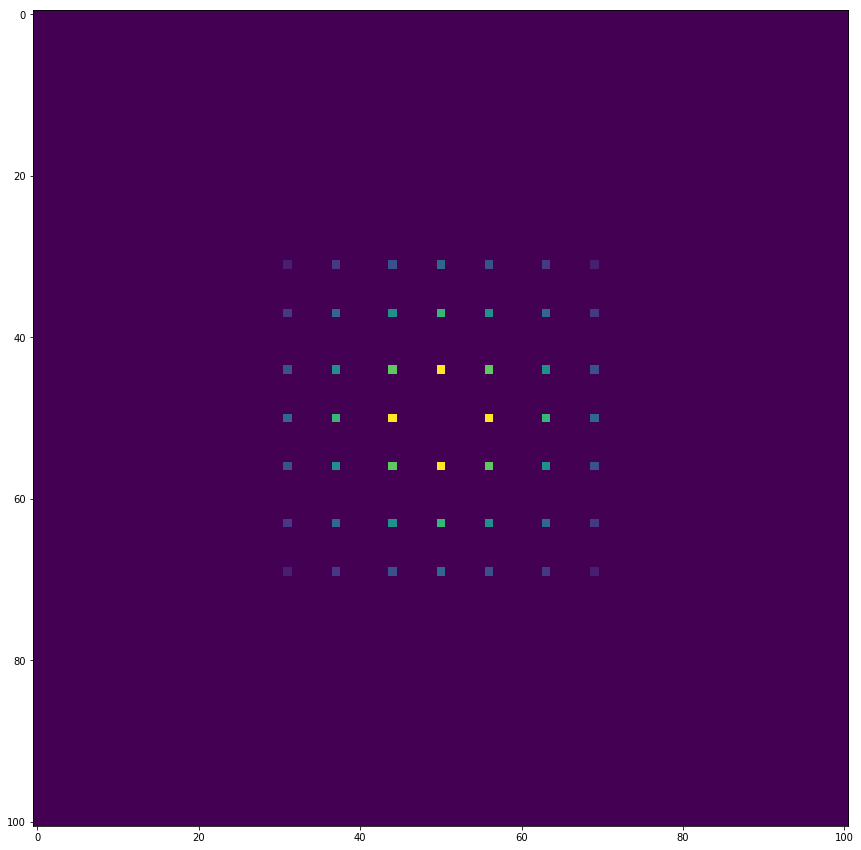

In [107]:
plt.figure(figsize=(15,15))
plt.imshow(uv)

In [108]:
beam = np.fft.fftshift(np.fft.fft2(uv))

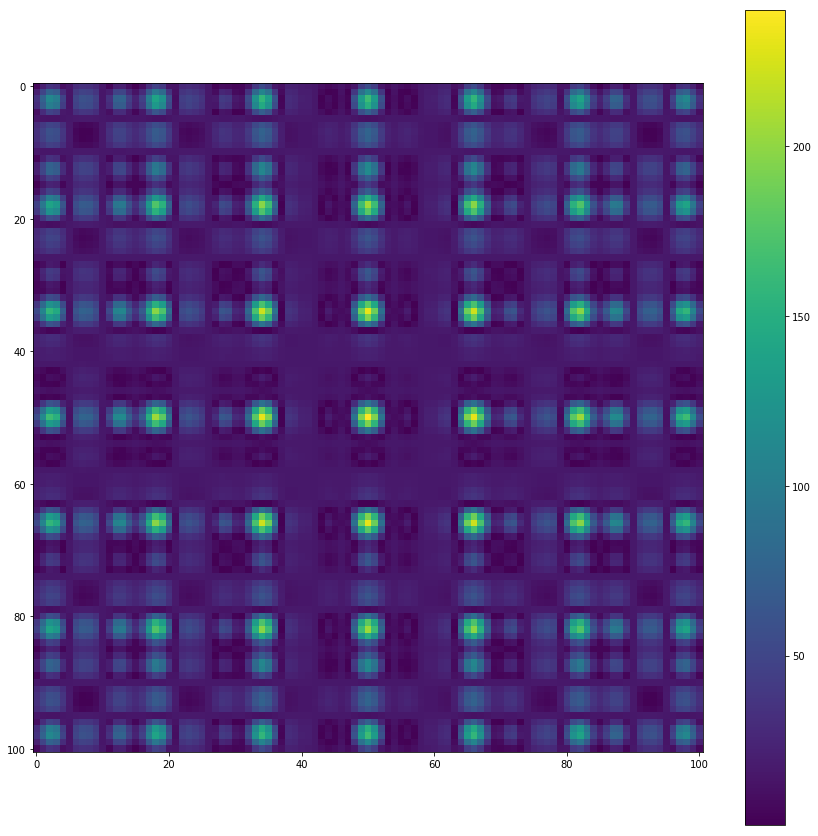

In [109]:
plt.figure(figsize=(15,15))
plt.imshow(np.absolute(beam))
plt.colorbar()

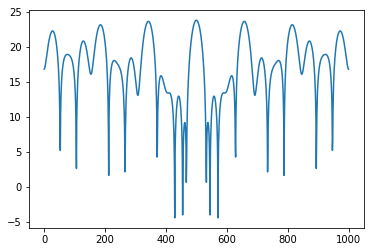

In [101]:
plt.plot(10*np.log10(np.absolute(beam[500])))